# Pytac & ATIP Combined Tutorial

First some required imports:

In [1]:
import pytac
import atip
import cothread
from matplotlib import pyplot as plt

## The Lattice and Elements in Pytac

Just like in PyAT, the central object in Pytac is the `lattice`, it holds all of the `elements` in the accelerator in order.

All the data about the lattice and its elements is stored in CSV files inside the Pytac repository. We use `load_csv.load` to load the data and initialise a `lattice` object.

Let's load the "I04" ring mode lattice with Pytac!

The "ring mode" is the name under which the configuration of the lattice is saved, there is one set of CSV files for each ring mode. So when we load the lattice, we specify the ring mode we want to load:

In [2]:
lattice = pytac.load_csv.load("I04", symmetry=24)

The lattice contains all the elements and can be indexed like a list, lets take a look at the first 5 elements:

In [3]:
for element in lattice[:5]:
    print(element)

<Element index 1, length 0.0 m, cell 1, families aperture, ap>
<Element index 2, length 4.38 m, cell 1, families drift, d1d2>
<Element index 3, length 0.0 m, cell 1, families bpm>
<Element index 4, length 1.2883 m, cell 1, families drift, kd1>
<Element index 5, length 0.4064 m, cell 1, families quadrupole, q1d>


Each element has certain identifying information:
 - `index` (its position in the lattice)
 - `s` (its s position - distance from the start of the lattice)
 - `cell` (which cell of the lattice it's in)
 - `families` (which families it belongs to, families are used to easily perform the same operation on a group of elements at the same time)
 - `name`
 - `type_` (types aren't strictly defined in Pytac, so users can use them to group elements however they want)
 - `length`

In [4]:
print(f"index: {lattice[7].index}")
print(f"s position: {lattice[7].s}")
print(f"cell: {lattice[5].cell}")
print(f"families: {lattice[7].families}")
print(f"name: {lattice[7].name}")
print(f"type: {lattice[7].type_}")
print(f"length: {lattice[7].length}")

index: 8
s position: 6.2265
cell: 1
families: {'squad', 'vstr', 's1d', 'sextupole', 'hstr'}
name: None
type: Sextupole
length: 0.29


Each element also has `fields` dictating what you can do with it:

In [5]:
print(f"a BPM's fields:\n{lattice[2].get_fields()}")
print(f"a Quadrupole's fields:\n{lattice[4].get_fields()}")

a BPM's fields:
{'live': dict_keys(['x', 'y', 'enabled', 'x_fofb_disabled', 'x_sofb_disabled', 'y_fofb_disabled', 'y_sofb_disabled'])}
a Quadrupole's fields:
{'live': dict_keys(['b1'])}


These are the field names used when getting and setting data:

In [6]:
print(lattice[4].get_value("b1"))

71.42195129394531


Similar to elements, the `lattice` object itself also has some `fields` of its own:

In [7]:
print(lattice.get_fields())
print(lattice.get_value("beam_current"))

{'live': dict_keys(['beam_current', 'emittance_x', 'emittance_y', 'tune_x', 'tune_y', 's_position', 'energy'])}
298.589851497948


This model of fields on the elements and lattice means that the user doesn't have to worry about dealing with PV names, but we can still see them if we want:

In [8]:
print(lattice[2].get_pv_name("x", pytac.RB))
print(lattice.get_pv_name("tune_x", pytac.RB))

SR01C-DI-EBPM-01:SA:X
SR23C-DI-TMBF-01:X:TUNE:TUNE


## Fundamental Operations in Pytac

First, let's look at families in a bit more detail.

Families are a way of grouping elements so that you can easily perform operations on just that subset of elements in the lattice. Let's see how you'd go about using them.

If you wanted to get all the elements from the `Q1D` family you would do:

In [9]:
print(lattice.get_elements("Q1D"))

[<Element index 5, length 0.4064 m, cell 1, families quadrupole, q1d>, <Element index 406, length 0.4064 m, cell 4, families quadrupole, q1d>, <Element index 427, length 0.4064 m, cell 5, families quadrupole, q1d>, <Element index 749, length 0.4064 m, cell 8, families quadrupole, q1d>, <Element index 805, length 0.4064 m, cell 9, families quadrupole, q1d>, <Element index 1152, length 0.4064 m, cell 12, families quadrupole, q1d>, <Element index 1208, length 0.4064 m, cell 13, families quadrupole, q1d>, <Element index 1506, length 0.4064 m, cell 16, families quadrupole, q1d>, <Element index 1515, length 0.4064 m, cell 17, families quadrupole, q1d>, <Element index 1857, length 0.4064 m, cell 20, families quadrupole, q1d>, <Element index 1875, length 0.4064 m, cell 21, families quadrupole, q1d>, <Element index 2187, length 0.4064 m, cell 24, families quadrupole, q1d>]


If you wanted to get the x values from all the BPMs in the ring you might do something like:

In [10]:
bpms = lattice.get_elements("BPM")
x_values = []
for bpm in bpms:
    x_values.append(bpm.get_value("x", data_source=pytac.LIVE, throw=False))
print(x_values[:5])

[-3e-06, 2.9999999999999997e-05, -2.2e-05, -2e-06, 1.2e-05]


This can be streamlined in Pytac to just:

In [11]:
x_values = lattice.get_element_values("BPM", "x", data_source=pytac.LIVE)
print(x_values[:5])

[-2e-06, 4e-06, -4.8e-05, 2.9e-05, 2.1e-05]


This is simpler for the user and is more efficient too as it will make use of batched operations, if your control system supports them.

### Getting & Setting

The interface for getting specific data is:

`get_value(field, handle=pytac.RB, units=pytac.DEFAULT, data_source=pytac.DEFAULT, throw=True)`

where:
 - `field` is the name of the field you want to get the value of
 - `handle` is either `pytac.RB` or `pytac.SP` depending on if you want to get the value of the readback PV or the setpoint PV
 - `units` is either `pytac.ENG` or `pytac.PHYS` depending on if you want the value to be returned in engineering or physics units
 - `data_source` is either `pytac.Live` or `pytac.SIM` depending on if you want to get your data from the live model or the simulator
 - `throw` is a boolean indicating if an error should be raised if the PV cannot be accessed

The interface for setting specific data is:

`set_value(field, value, units=pytac.DEFAULT, data_source=pytac.DEFAULT, throw=True)`

where:
 - `field` is the name of the field you want to set the value of
 - `value` is the value that you want to set to the field
 - `units` is either `pytac.ENG` or `pytac.PHYS` depending on if the value you are setting is in engineering or physics units
 - `data_source` is either `pytac.Live` or `pytac.SIM` depending on if you want to set your data to the live model or the simulator
 - `throw` is a boolean indicating if an error should be raised if the PV cannot be accessed

The default values for the `units` and `data_source` arguments are `pytac.ENG` and `pytac.LIVE` respectively, but the defaults can also be configured on the lattice:

In [12]:
print(lattice[4].get_value("b1"))
lattice.set_default_units(pytac.PHYS)
print(lattice[4].get_value("b1"))
# We haven't actually got a simulator data source loaded yet
lattice.set_default_data_source(pytac.SIM)
try:
    lattice[4].get_value("b1")
except pytac.exceptions.DataSourceException:
    pass
# So let's set it back for now, we'll look at data sources more in a bit
lattice.set_default_data_source(pytac.LIVE)

71.41854095458984
-0.7052477981638743


### Units

Pytac handles the conversion between different unit types automatically whenever it's required. This is done using the `UnitConv` class, each field has its own UnitConv object that performs the conversions for it based on the stored conversion transformation.

These conversions can be between different unit systems:

In [13]:
print(lattice[4].get_unitconv("b1").eng_units)
print(lattice[4].get_unitconv("b1").phys_units)

A
m^-2


Or just different magnitudes:

In [14]:
print(lattice[2].get_unitconv("x").eng_units)
print(lattice[2].get_unitconv("x").phys_units)

m
mm


### Handles


Fields that you can set data to will have two PVs associated with them; a setpoint PV, which is the target value that the hardware is trying to reach, and a readback PV, which is the actual value from the hardware right now.

Handles are how Pytac knows whether to get the value of the setpoint or readback PV.

In a real-world accelerator, these will usually have slightly different values:

In [15]:
print(lattice[4].get_value("b1", handle=pytac.RB))
print(lattice[4].get_value("b1", handle=pytac.SP))

-0.7052477981638743
-0.7052395948755767


Some fields cannot be set to and so will only have a readback PV, e.g. `x` on a BPM:

In [16]:
print(lattice[2].get_value("x", handle=pytac.RB))
try:
    lattice[2].get_value("x", handle=pytac.SP)
except pytac.exceptions.HandleException as e:
    print(e)

-4e-09
Device SR01C-DI-EBPM-01 has no setpoint PV.


### Data Sources

Pytac is most commonly used for getting and setting data to/from the real accelerator using the "live" data source. However, Pytac can also be set up with an additional simulated data source.

We use ATIP to load a PyAT simulation, based on our `.mat` AT lattice file, onto our Pytac lattice as a "simulation" data source.

So let's do that:

In [17]:
lattice = atip.load_sim.load_from_filepath(lattice, "atip/rings/I04.mat")

Let's check the element and lattice fields again:

In [18]:
print(lattice[4].get_fields())
print(lattice.get_fields())

{'live': dict_keys(['b1']), 'simulation': ['b1']}
{'live': dict_keys(['beam_current', 'emittance_x', 'emittance_y', 'tune_x', 'tune_y', 's_position', 'energy']), 'simulation': ['chromaticity_x', 'chromaticity_y', 'chromaticity', 'eta_prime_x', 'eta_prime_y', 'dispersion', 'emittance_x', 'emittance_y', 'emittance', 'closed_orbit', 'eta_x', 'eta_y', 'energy', 'phase_x', 'phase_y', 's_position', 'tune_x', 'tune_y', 'alpha', 'beta', 'tune', 'm66', 'x', 'y', 'mu']}


Now we can see that there are fields available on both the `live` and `simulation` data sources, and on the lattice there are some additional new fields. A general rule is that if a field is available on the live machine it should also be present in the simulation, but the simulation can also have extra fields for data that we don't have in the real world.

## Using the Simulated Data Source

Now that we've loaded the simulator onto the lattice, let's see how to use it. First, let's compare some lattice fields between the live machine and the simulator, e.g. tunes:

In [19]:
print(f"live machine tunes: [{lattice.get_value('tune_x', data_source=pytac.LIVE):.5f}, {lattice.get_value('tune_y', data_source=pytac.LIVE):.5f}]")
print(f"simulator tunes:    [{lattice.get_value('tune_x', data_source=pytac.SIM):.5f}, {lattice.get_value('tune_y', data_source=pytac.SIM):.5f}]")

live machine tunes: [0.18931, 0.27688]
simulator tunes:    [0.18906, 0.27703]


As we would expect the values differ slightly. It's also interesting to look at the values over time:

In [20]:
def check_5Hz(lattice, data_source, n):
    values = []
    for _ in range(n):
        values.append(lattice.get_value("tune_x", data_source=data_source))
        cothread.Sleep(0.2)
    return values

print(check_5Hz(lattice, pytac.LIVE, 5))
print(check_5Hz(lattice, pytac.SIM, 5))

[0.1893075790305403, 0.1893075790305403, 0.18869013546969882, 0.18869013546969882, 0.18869013546969882]
[0.18906259277754422, 0.18906259277754422, 0.18906259277754422, 0.18906259277754422, 0.18906259277754422]


Unlike the value from the live machine, the value from the simulator hasn't fluctuated at all; this is because of how the simulator functions. Simply put, the simulator only updates the physics data (beam position, tune, emittance, etc.) each time a change to the lattice is made so that it's not constantly doing needless calculations in the background.

If we slightly change a magnet we will see the tunes from the simulator update accordingly:

In [21]:
print(f"tunes before: [{lattice.get_value('tune_x', data_source=pytac.SIM):.5f}, {lattice.get_value('tune_y', data_source=pytac.SIM):.5f}]")
quad = lattice.get_elements("quadrupole")[0]
quad.set_value("b1", -0.71, data_source=pytac.SIM)
print(f"tunes after:  [{lattice.get_value('tune_x', data_source=pytac.SIM):.5f}, {lattice.get_value('tune_y', data_source=pytac.SIM):.5f}]")

tunes before: [0.18906, 0.27703]
tunes after:  [0.18479, 0.28036]


Now let's plot the `x` values for all the BPMs in the lattice for the live machine:

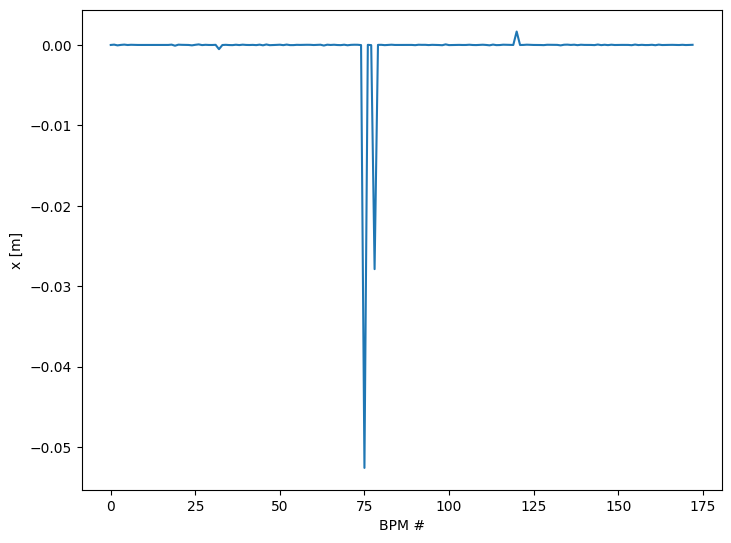

In [22]:
x_values = lattice.get_element_values("BPM", "x", units=pytac.ENG, data_source=pytac.LIVE)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel("BPM #")
ax.set_ylabel("x [m]")
ax.plot(range(len(x_values)), x_values)
plt.show()

Now let's see what the BPMs from the simulator are reading:

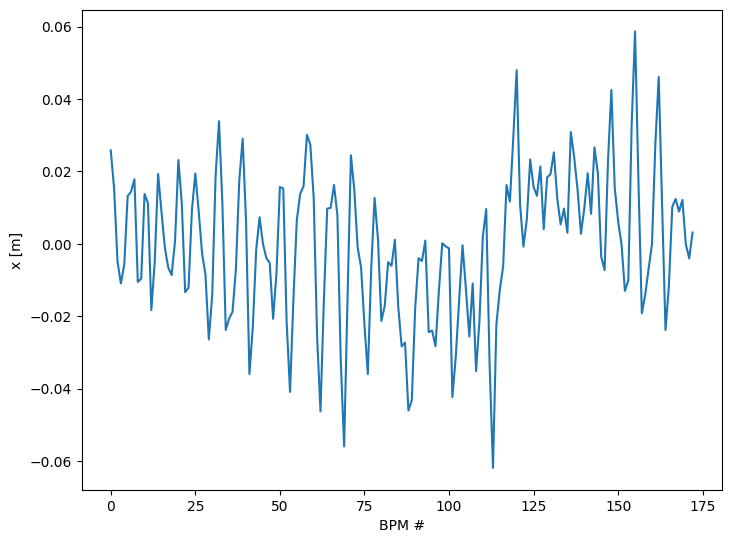

In [23]:
initial_x_values = lattice.get_element_values("BPM", "x", units=pytac.ENG, data_source=pytac.SIM)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel("BPM #")
ax.set_ylabel("x [m]")
ax.plot(range(len(initial_x_values)), initial_x_values)
plt.show()

Now let's change one of the correctors and see what happens:

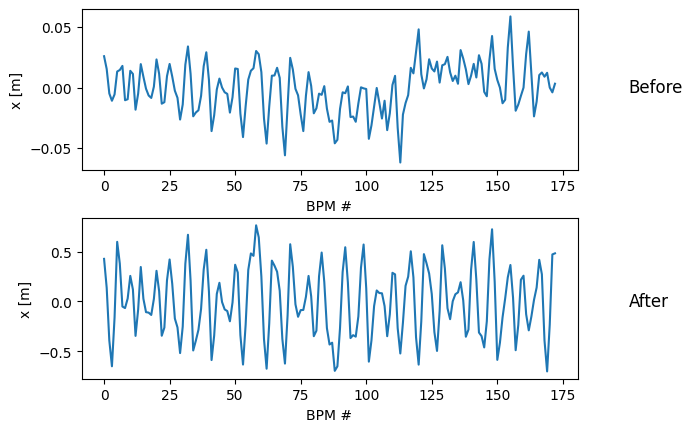

In [24]:
# Display our initial BPM x positions for reference
fig = plt.figure()
fig.subplots_adjust(hspace=0.3)
ax1 = fig.add_subplot(2,1,1)
ax1.set_xlabel("BPM #")
ax1.set_ylabel("x [m]")
ax1.ticklabel_format(style="plain")
ax1.text(200, 0, "Before", fontsize=12, va="center")
ax1.plot(range(len(initial_x_values)), initial_x_values)

# Change the x_kick of one of the corrector magnets
hcor10 = lattice.get_elements("HSTR")[10]
hcor10.set_value("x_kick", 0.0001, units=pytac.PHYS, data_source=pytac.SIM)

# Make sure the calculations are complete so we get up-to-date values
simulator = atip.utils.get_atsim(lattice)
simulator.wait_for_calculations()

# Measure and plot the BPM x positions after the change
new_x_values = lattice.get_element_values("BPM", "x", units=pytac.ENG, data_source=pytac.SIM)
ax2 = fig.add_subplot(2,1,2)
ax2.set_xlabel("BPM #")
ax2.set_ylabel("x [m]")
ax2.text(200, 0, "After", fontsize=12, va="center")
ax2.plot(range(len(new_x_values)), new_x_values)
plt.show()

So as we can see (look at the magnitude of the y-axis in particular), we have changed a corrector magnet slightly and our simulator has performed calculations in the background and updated the BPM values with the new orbit values.

## Virtac

In addition to plugging into Pytac, ATIP also includes a standalone virtual accelerator. This means that high-level applications that don't use Pytac can still be tested against the simulator.

Using PythonSoftIOC, it emulates PVs so that the ATIP simulator can be addressed in the same manner as the live machine. This means that, rather than having to use Pytac, applications can address the PVs as they normally would on the live machine and ATIP will update the PVs in a physically correct manner.

**Demo virtac in terminals?**

# End of Demo 

In [25]:
# Blank code box to answer questions in if needed